<a href="https://colab.research.google.com/github/mugilan0606/Dog-Breed-Prediction/blob/main/DogBreed_Prediction_using_Pretrained_VGG19_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [ ]:
!pip install -q keras

In [ ]:
import os
import numpy as np
import pandas as pd
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.applications.resnet50 import preprocess_input
#from keras.applications.ResNet50 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications import imagenet_utils

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from keras.callbacks import EarlyStopping
from collections import Counter

### train dir contains images

In [ ]:

data_dir = '/content/drive/MyDrive/train'
files = os.listdir(data_dir)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Target Information from labels.csv

In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/labels.csv')
labels.count()
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,d686e2bf8438d2a5c29924efca616708,scottish_deerhound
freq,1,126


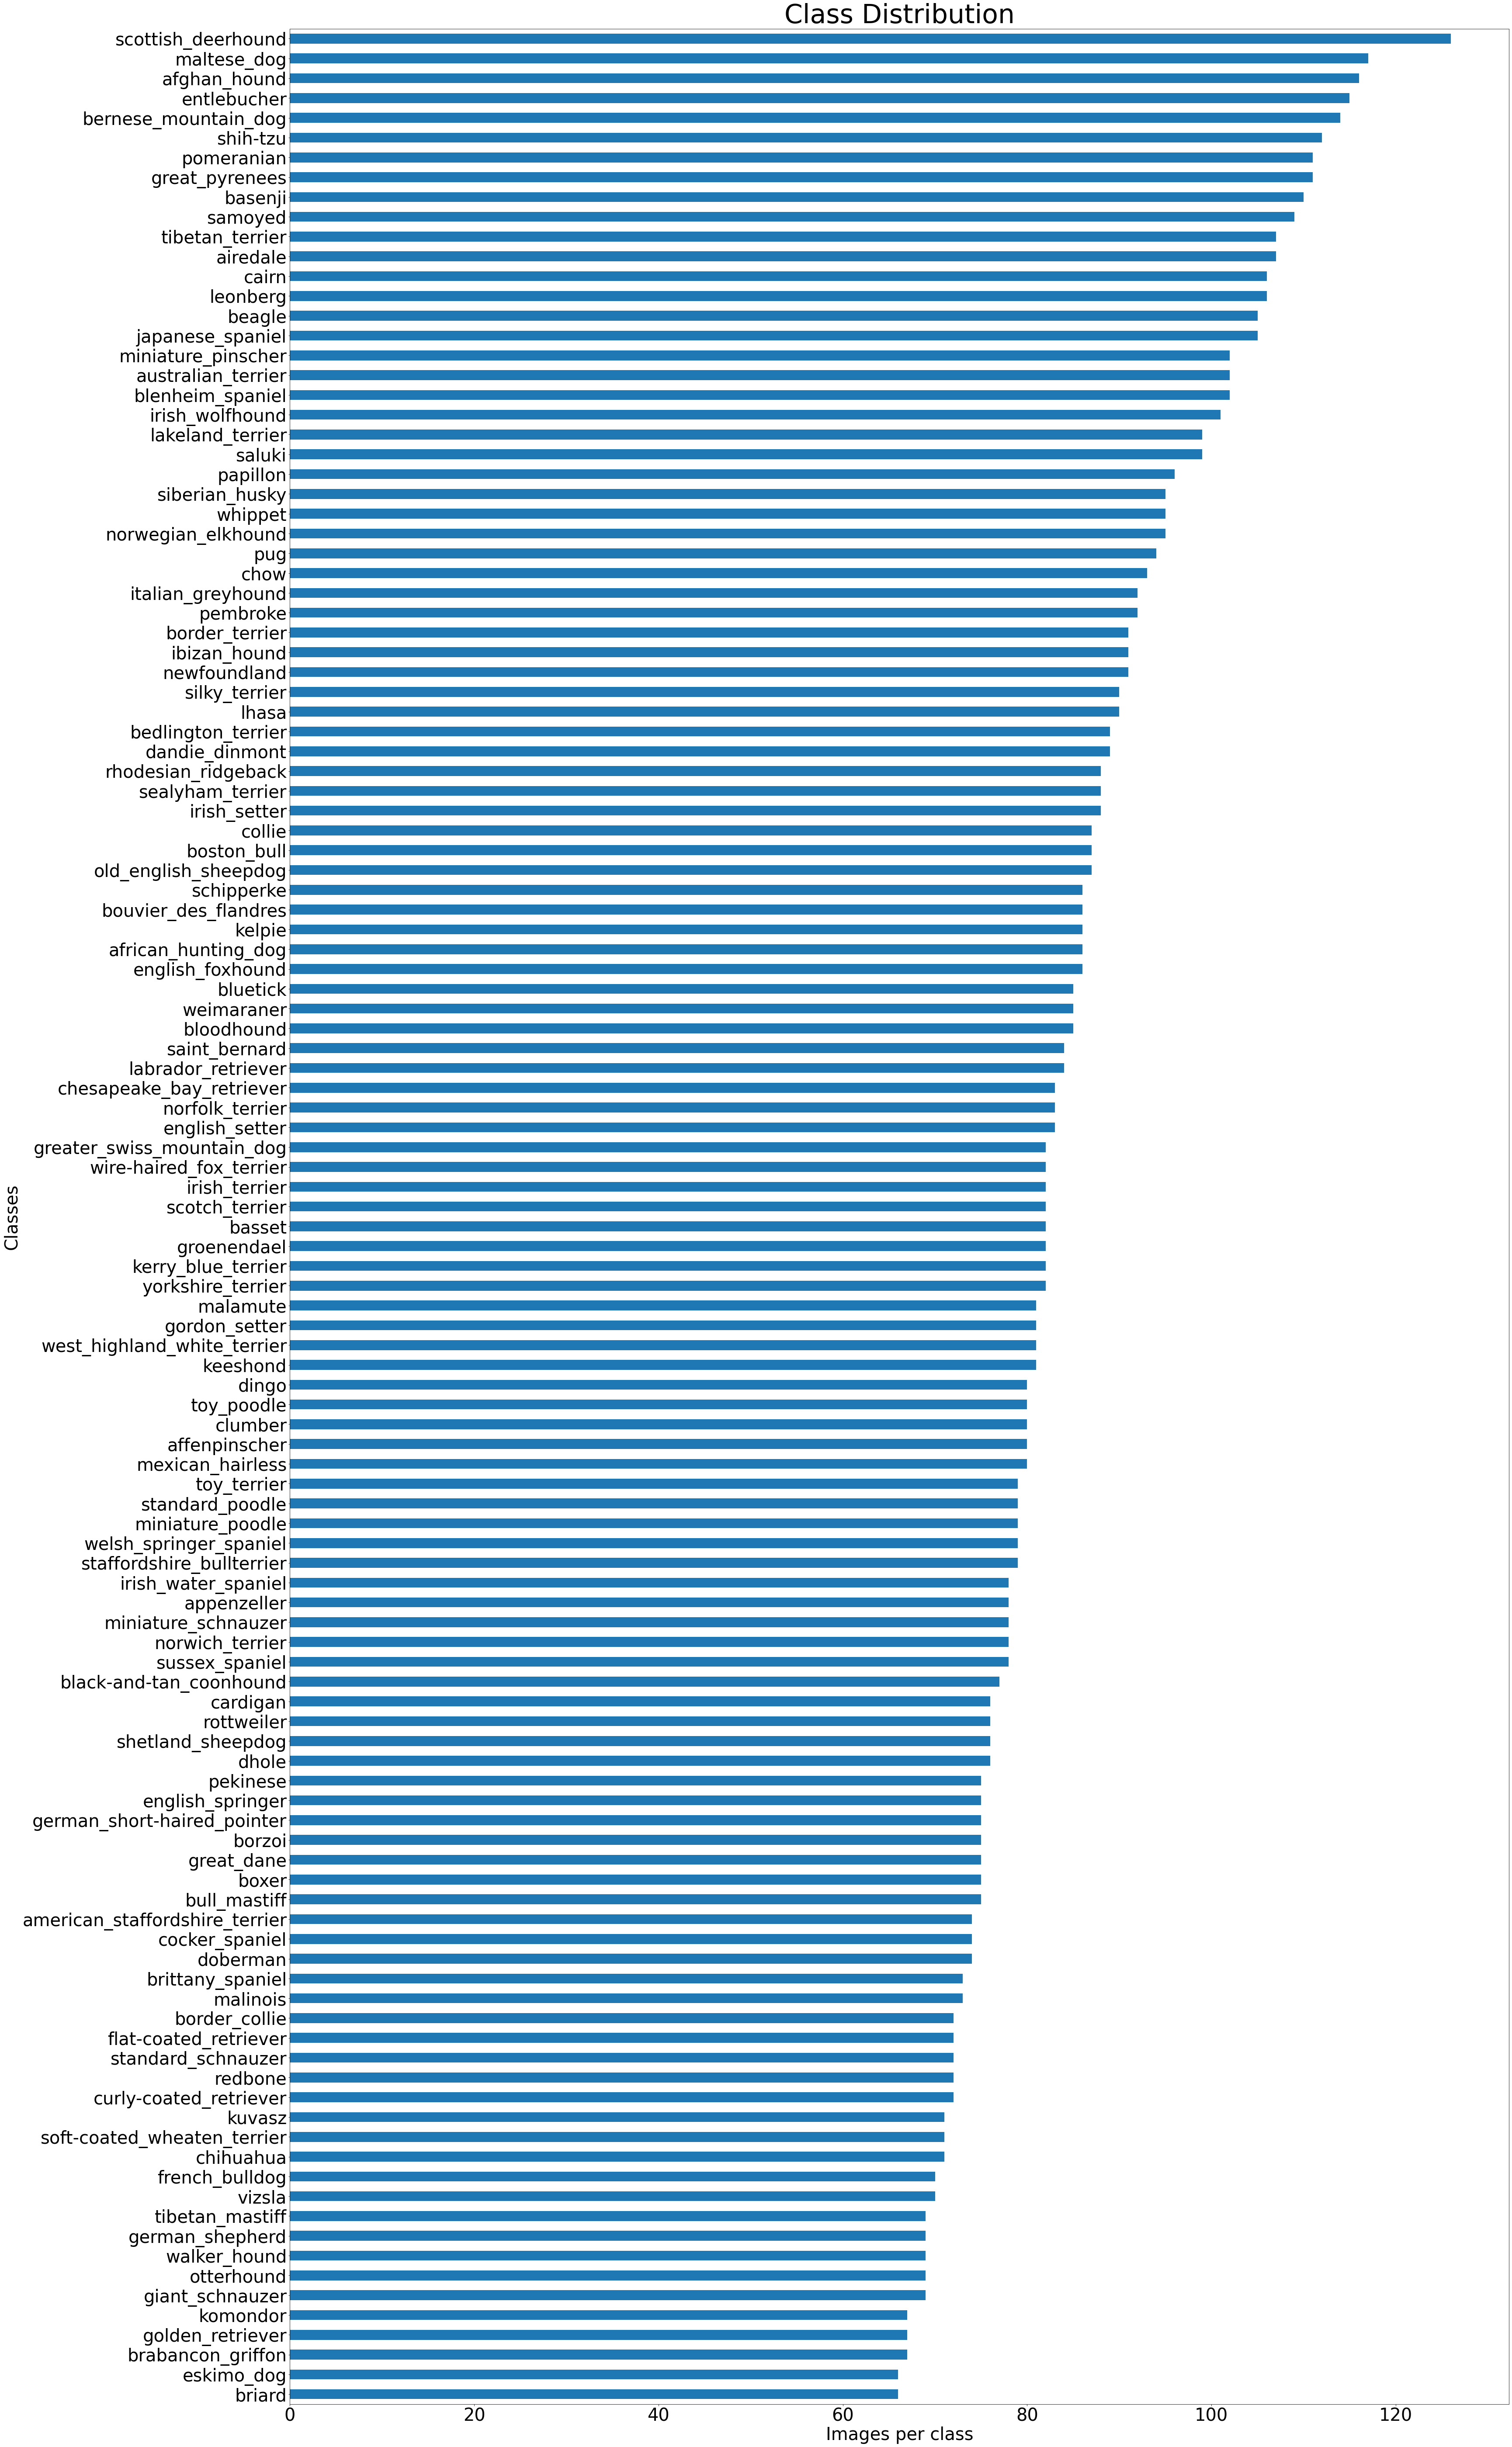

In [ ]:
ax=pd.value_counts(labels['breed'],ascending=True).plot(kind='barh',fontsize="40",title="Class Distribution",figsize=(50,100))
ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)
ax.title.set_size(60)
plt.show()
#plt.figure(figsize=(50,20))

In [ ]:

data=Counter(list(labels['breed']))
sort_data = sorted(data.items(), key=lambda x: x[1], reverse=True)
sort_data=pd.DataFrame(sort_data[:20],columns=["breed","count"])
labels2=[]
l=list(sort_data["breed"][0:])
for i in range(len(labels["breed"])):
    #print(labels.iloc[i]["breed"])
    if labels.iloc[i]["breed"] in l:
        
        labels2.append([labels.iloc[i]["breed"],labels.iloc[i]["id"]])
labels=pd.DataFrame(labels2,columns=["breed","id"])
labels[labels["breed"]=="australian_terrier"]       

,breed,id
6,australian_terrier,0192d7174233ebdb3d720000413829ac
43,australian_terrier,05c128c8e3ef0c2739f181f9c5677f56
82,australian_terrier,0995f642fe4baab3cb3534725dfedb75
90,australian_terrier,0a9322a30aff755dac328022266e3740
117,australian_terrier,0dc45e3e57bbcfccc550479d57b39951
...,...,...
2055,australian_terrier,f0649324ca9ee431d8c37ef361a0d9fd
2130,australian_terrier,f922fcb519e1f55ca99e8c3bb9e07619
2153,australian_terrier,fbf3162c4df3f1a527cb0b26ef062704
2168,australian_terrier,fede60fb2acc02a2da0d0a05f760b7d5


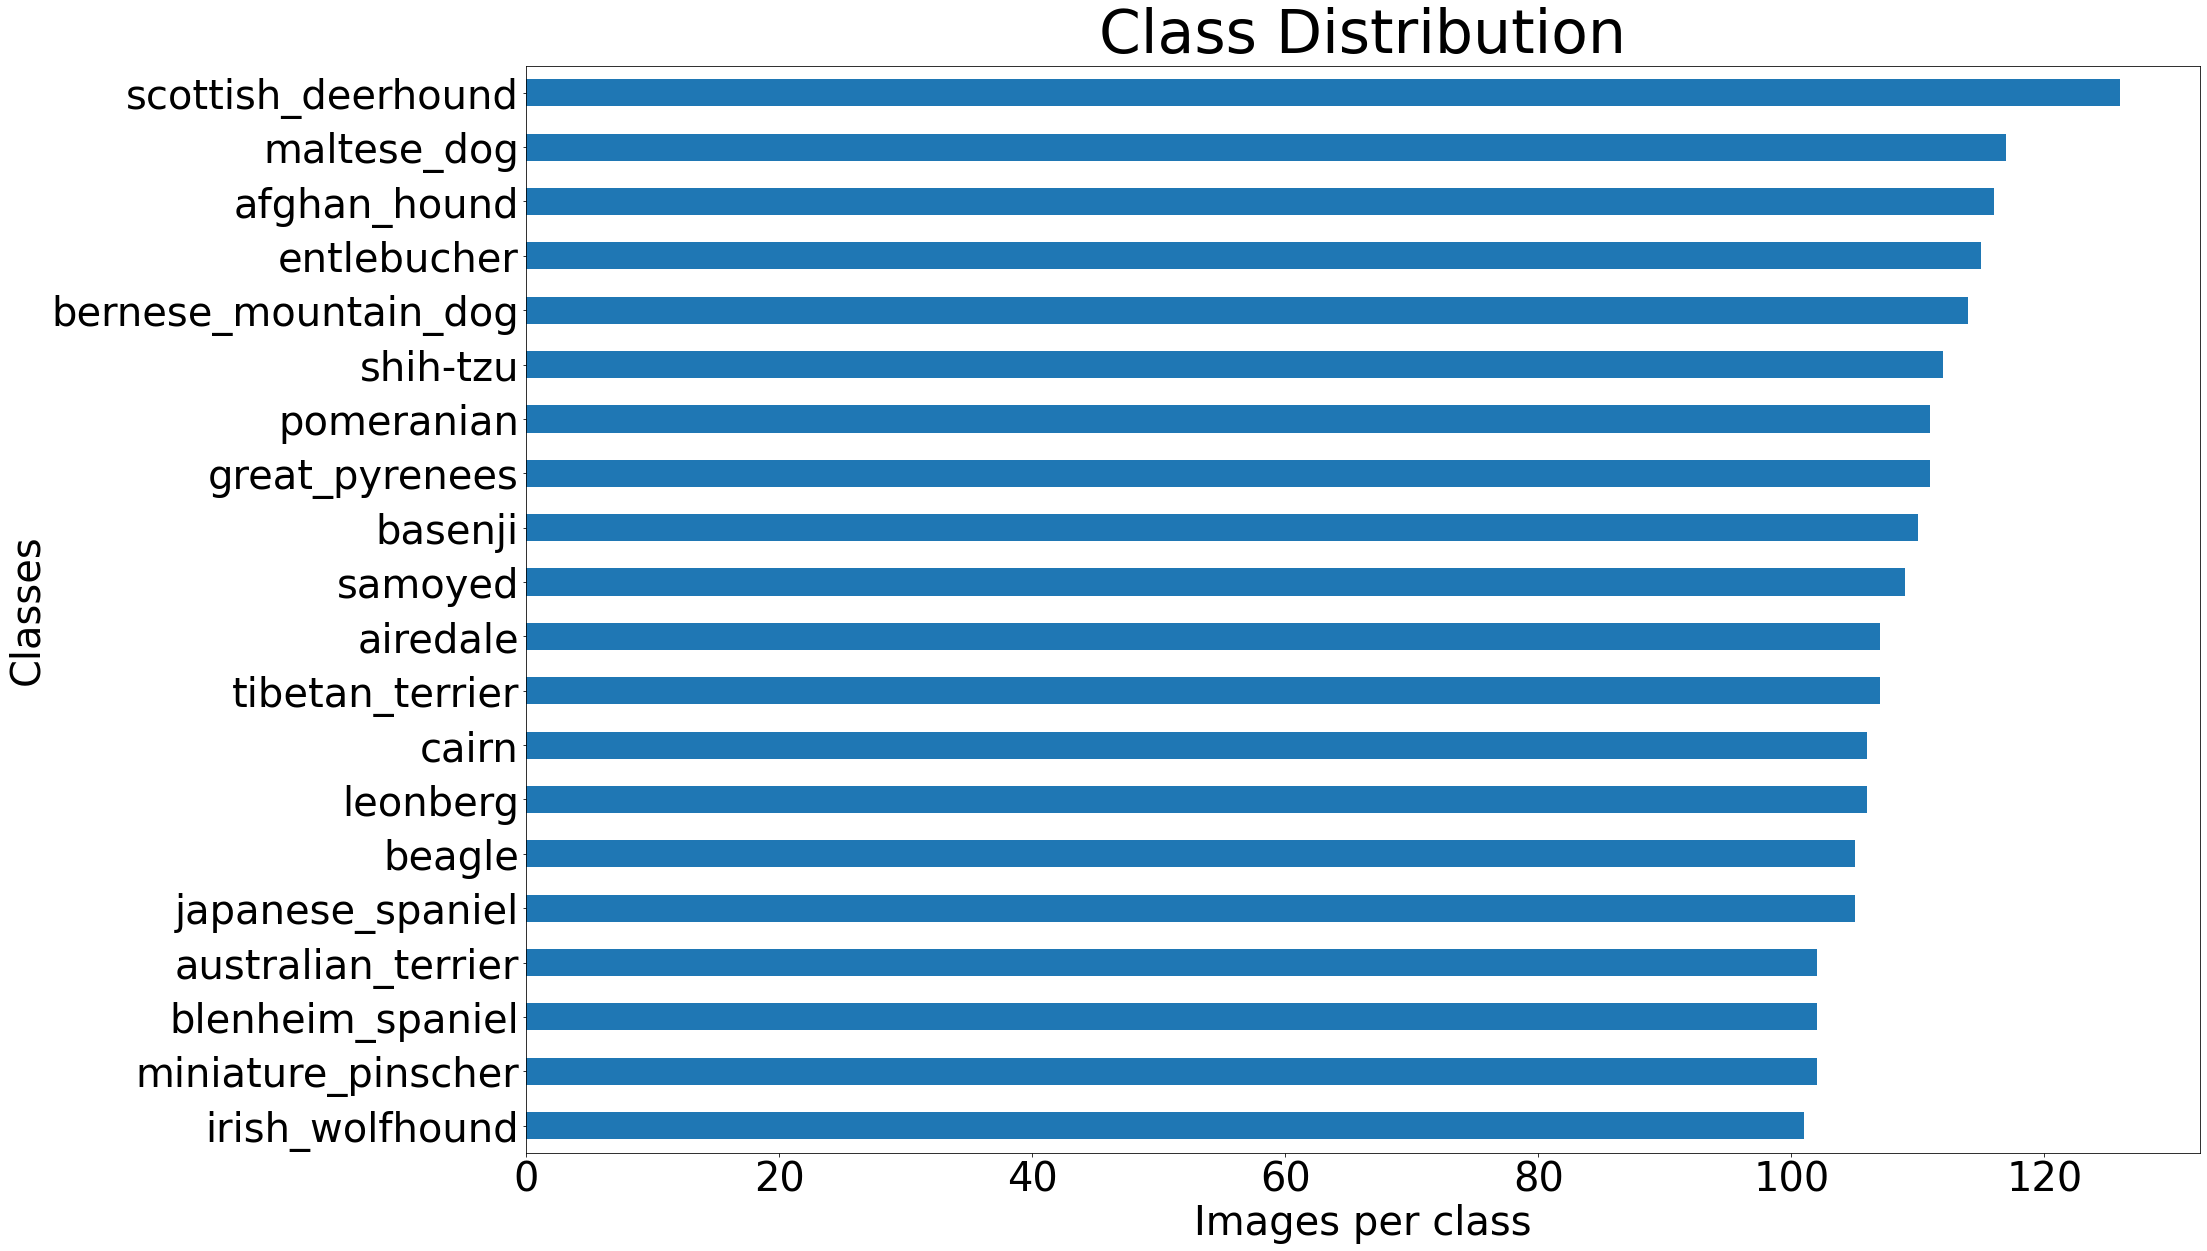

In [ ]:
ax=pd.value_counts(labels['breed'],ascending=True).plot(kind='barh',fontsize="40",title="Class Distribution",figsize=(30,20))
ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)
ax.title.set_size(60)
plt.show()

In [ ]:
file_df = pd.DataFrame({'id':list(map(lambda x:x.replace('.jpg',''),files))})
file_df.head()

,id
0,e63ce7912e8a260513f3d4d9db3eaa62
1,dbb75e40f88b9703dbfe196f6ec57b3b
2,dd1b3f07d67fc801884d25d085441f06
3,e9711a024b141baa00e640231bc461a9
4,e34ee9dce9546a1b520c1c8a3badb605


### Mapping File with breed, maintain file read order

In [ ]:
label_info = pd.merge(left=file_df, right=labels)
label_info.head()
#label_info[label_info['id']=='0a27d304c96918d440e79e6e9e245c3f']    

,id,breed
0,dcfe4f0f7d7c091e8488bff8662582be,bernese_mountain_dog
1,dfdb153c5100737c782c5f9578717594,basenji
2,e79c6a88cf8da397ee67235a04741f2d,shih-tzu
3,dd6482115d974cab92c9428c9a6fe29f,afghan_hound
4,dddece0d4f1ff6795a125836e4a88e07,afghan_hound


### showing a few of them
#### 1st Image

In [ ]:
img = plt.imread(os.path.join(data_dir,files[5]))

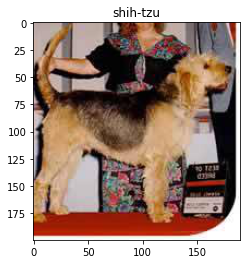

In [ ]:
plt.imshow(img)
plt.title(label_info.iloc[5]['breed'])
plt.show()

### Converting target to One-Hot-Vector Format

In [ ]:
num_classes = len(label_info.breed.unique())
num_classes

20

2184


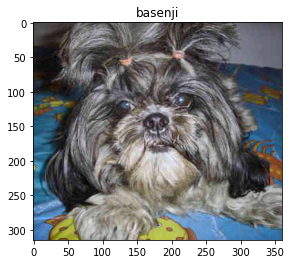

In [ ]:

files2=list(labels["id"])
files2=[x+".jpg" for x in files2]
files=files2.copy()
print(len(list(labels["id"])))
img = plt.imread(os.path.join(data_dir,files[5]))
plt.imshow(img)
plt.title(label_info.iloc[1]['breed'])
plt.show()

In [ ]:
le = LabelEncoder()
breed = le.fit_transform(label_info.breed)

Y = np_utils.to_categorical(breed,num_classes=num_classes)
breed


array([ 5,  3, 18, ...,  3,  9,  4])

In [ ]:
Y.shape

(2184, 20)

### Convert images to numpy array

In [ ]:
input_dim = (224, 224)

X = np.zeros((Y.shape[0],*input_dim,3))

for i,img in enumerate(files):
    
    #print(img)
    image = load_img(os.path.join(data_dir,img),target_size=input_dim)
    image = img_to_array(image)
    image = image.reshape((1, *image.shape))
    image = preprocess_input(image)
    X[i] = image

In [ ]:
X.shape

(2184, 224, 224, 3)

### Create callbacks

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

# Image augmentation...

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

In [ ]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [ ]:
datagen.fit(X)

In [ ]:
model = load_model('/content/drive/MyDrive/modelfew2layer.h5')

In [ ]:
batch_size=256
history_aug_images = model.fit_generator(datagen.flow(X, Y, batch_size=256), steps_per_epoch=len(X) // batch_size, epochs=9, verbose=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/9
8/8 - 121s - loss: 2.8219 - accuracy: 0.1504 - 121s/epoch - 15s/step
Epoch 2/9
8/8 - 29s - loss: 2.7838 - accuracy: 0.1686 - 29s/epoch - 4s/step
Epoch 3/9
8/8 - 31s - loss: 2.7613 - accuracy: 0.1787 - 31s/epoch - 4s/step
Epoch 4/9
8/8 - 29s - loss: 2.7457 - accuracy: 0.1784 - 29s/epoch - 4s/step
Epoch 5/9
8/8 - 29s - loss: 2.7356 - accuracy: 0.1732 - 29s/epoch - 4s/step
Epoch 6/9
8/8 - 29s - loss: 2.7368 - accuracy: 0.1712 - 29s/epoch - 4s/step
Epoch 7/9
8/8 - 29s - loss: 2.7034 - accuracy: 0.1898 - 29s/epoch - 4s/step
Epoch 8/9
8/8 - 29s - loss: 2.6819 - accuracy: 0.1893 - 29s/epoch - 4s/step
Epoch 9/9
8/8 - 31s - loss: 2.6521 - accuracy: 0.2065 - 31s/epoch - 4s/step


In [ ]:
history_aug_images.history.keys()

dict_keys(['loss', 'accuracy'])

In [ ]:
model.save('/content/drive/MyDrive/img_aug.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/img_aug.h5')
image = load_img('/content/drive/MyDrive/train/05c128c8e3ef0c2739f181f9c5677f56.jpg',target_size=input_dim)
image = img_to_array(image)
image = image.reshape((1, *image.shape))
image = preprocess_input(image)

In [ ]:
res = model.predict(image)

In [ ]:
s = np.argsort(res)[0][-5:]
s

array([ 4, 15,  1,  2,  6])

In [ ]:
le.inverse_transform(s)

array(['beagle', 'pomeranian', 'airedale', 'australian_terrier',
       'blenheim_spaniel'], dtype=object)

In [ ]:
'''image = load_img('/content/drive/MyDrive/train/05c128c8e3ef0c2739f181f9c5677f56.jpg',target_size=input_dim)
image = img_to_array(image
image = image.reshape((1, *image.shape))
image = preprocess_input(image)'''

In [ ]:
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense,GlobalAveragePooling2D, Flatten,Dropout

vgg_model = VGG19(weights='imagenet', include_top=False)

x = vgg_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
out = Dense(20, activation='softmax')(x)

model = Model(inputs=vgg_model.input, outputs=out)

for layer in vgg_model.layers:
    layer.trainable = False

from tensorflow.keras.optimizers import Adam
opt = Adam()

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

80150528/80134624 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [ ]:
history_last_layer = model.fit(X,Y,batch_size=256,epochs=20,validation_split=0.2,verbose=2,callbacks=[earlystop])
model.save('/content/drive/MyDrive/modellastlayer.h5')

Epoch 1/20
7/7 - 179s - loss: 16.7147 - accuracy: 0.0624 - val_loss: 12.7330 - val_accuracy: 0.0503 - 179s/epoch - 26s/step
Epoch 2/20
7/7 - 18s - loss: 14.5583 - accuracy: 0.0504 - val_loss: 11.9268 - val_accuracy: 0.0572 - 18s/epoch - 3s/step
Epoch 3/20
7/7 - 18s - loss: 13.2944 - accuracy: 0.0544 - val_loss: 10.9299 - val_accuracy: 0.0503 - 18s/epoch - 3s/step
Epoch 4/20
7/7 - 18s - loss: 12.4184 - accuracy: 0.0693 - val_loss: 10.2326 - val_accuracy: 0.0549 - 18s/epoch - 3s/step
Epoch 5/20
7/7 - 18s - loss: 11.6316 - accuracy: 0.0630 - val_loss: 9.5891 - val_accuracy: 0.0458 - 18s/epoch - 3s/step
Epoch 6/20
7/7 - 18s - loss: 10.8816 - accuracy: 0.0664 - val_loss: 9.2512 - val_accuracy: 0.0503 - 18s/epoch - 3s/step
Epoch 7/20
7/7 - 18s - loss: 10.4417 - accuracy: 0.0756 - val_loss: 9.0472 - val_accuracy: 0.0526 - 18s/epoch - 3s/step
Epoch 8/20
7/7 - 18s - loss: 9.8271 - accuracy: 0.0738 - val_loss: 8.7072 - val_accuracy: 0.0526 - 18s/epoch - 3s/step
Epoch 9/20
7/7 - 18s - loss: 9.309

### Apart from last layer, training one more layer

In [ ]:
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense,GlobalAveragePooling2D, Flatten,Dropout

vgg_model = VGG19(weights='imagenet', include_top=False)

x = vgg_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
out = Dense(20, activation='softmax')(x)

model_few_layers = Model(inputs=vgg_model.input, outputs=out)

for layer in vgg_model.layers[:-1]:
    layer.trainable = False

for layer in vgg_model.layers[-1:]:
    layer.trainable = True

from tensorflow.keras.optimizers import Adam
opt = Adam()

model_few_layers.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model_few_layers.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [ ]:
history_few_layers = model_few_layers.fit(X,Y,batch_size=256,epochs=20,validation_split=0.2,verbose=2,callbacks=[earlystop])
model_few_layers.save('/content/drive/MyDrive/modelfewlayer.h5')

Epoch 1/20
7/7 - 182s - loss: 18.5690 - accuracy: 0.0521 - val_loss: 12.4965 - val_accuracy: 0.0526 - 182s/epoch - 26s/step
Epoch 2/20
7/7 - 19s - loss: 16.1962 - accuracy: 0.0452 - val_loss: 11.7096 - val_accuracy: 0.0503 - 19s/epoch - 3s/step
Epoch 3/20
7/7 - 19s - loss: 15.1083 - accuracy: 0.0647 - val_loss: 10.7715 - val_accuracy: 0.0526 - 19s/epoch - 3s/step
Epoch 4/20
7/7 - 19s - loss: 14.2881 - accuracy: 0.0498 - val_loss: 10.1810 - val_accuracy: 0.0503 - 19s/epoch - 3s/step
Epoch 5/20
7/7 - 19s - loss: 13.3731 - accuracy: 0.0618 - val_loss: 9.4452 - val_accuracy: 0.0595 - 19s/epoch - 3s/step
Epoch 6/20
7/7 - 19s - loss: 12.8856 - accuracy: 0.0544 - val_loss: 8.9063 - val_accuracy: 0.0618 - 19s/epoch - 3s/step
Epoch 7/20
7/7 - 19s - loss: 12.1380 - accuracy: 0.0727 - val_loss: 8.5899 - val_accuracy: 0.0664 - 19s/epoch - 3s/step
Epoch 8/20
7/7 - 19s - loss: 11.4543 - accuracy: 0.0721 - val_loss: 8.3298 - val_accuracy: 0.0595 - 19s/epoch - 3s/step
Epoch 9/20
7/7 - 19s - loss: 11.0

## Trained last few layers

In [ ]:
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense,GlobalAveragePooling2D, Flatten,Dropout

vgg_model = VGG19(weights='imagenet', include_top=False)

x = vgg_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
out = Dense(20, activation='softmax')(x)

model_few2_layers = Model(inputs=vgg_model.input, outputs=out)

for layer in vgg_model.layers[:-2]:
    layer.trainable = False

for layer in vgg_model.layers[-2:]:
    layer.trainable = True

from tensorflow.keras.optimizers import Adam
opt = Adam()

model_few2_layers.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model_few2_layers.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
history_few2_layers = model_few2_layers.fit(X,Y,batch_size=256,epochs=20,validation_split=0.2,verbose=2)
model_few2_layers.save('/content/drive/MyDrive/modelfew2layer.h5')

Epoch 1/20
7/7 - 163s - loss: 27.4085 - accuracy: 0.0601 - val_loss: 5.9019 - val_accuracy: 0.0572 - 163s/epoch - 23s/step
Epoch 2/20
7/7 - 20s - loss: 3.9049 - accuracy: 0.0824 - val_loss: 3.0634 - val_accuracy: 0.0595 - 20s/epoch - 3s/step
Epoch 3/20
7/7 - 20s - loss: 2.9348 - accuracy: 0.0870 - val_loss: 3.0129 - val_accuracy: 0.0389 - 20s/epoch - 3s/step
Epoch 4/20
7/7 - 20s - loss: 2.8672 - accuracy: 0.1099 - val_loss: 3.0532 - val_accuracy: 0.0481 - 20s/epoch - 3s/step
Epoch 5/20
7/7 - 20s - loss: 2.7965 - accuracy: 0.1265 - val_loss: 3.1072 - val_accuracy: 0.0435 - 20s/epoch - 3s/step
Epoch 6/20
7/7 - 20s - loss: 2.6915 - accuracy: 0.1580 - val_loss: 3.1404 - val_accuracy: 0.0595 - 20s/epoch - 3s/step
Epoch 7/20
7/7 - 20s - loss: 2.5873 - accuracy: 0.1918 - val_loss: 3.1872 - val_accuracy: 0.0595 - 20s/epoch - 3s/step
Epoch 8/20
7/7 - 20s - loss: 2.4341 - accuracy: 0.2433 - val_loss: 3.2052 - val_accuracy: 0.0595 - 20s/epoch - 3s/step
Epoch 9/20
7/7 - 20s - loss: 2.2931 - accura

In [ ]:
from keras import models
model = models.load_model('/content/drive/MyDrive/modelfew2layer.h5')

In [ ]:

last_layer_model = models.load_model('/content/drive/MyDrive/modelfew2layer.h5')
res = last_layer_model.predict(image)
s = np.argsort(res)[0][-5:]
s
le.inverse_transform(s)

array(['japanese_spaniel', 'miniature_pinscher', 'basenji', 'cairn',
       'blenheim_spaniel'], dtype=object)

In [ ]:
image = load_img('/content/drive/MyDrive/test/2.jpg',target_size=input_dim)
image = img_to_array(image)
image = image.reshape((1, *image.shape))
image = preprocess_input(image)

In [ ]:
image.shape

(1, 224, 224, 3)

In [ ]:
res = model.predict(image)

In [ ]:
s = np.argsort(res)[0][-5:]
s

array([ 8, 14,  0,  2,  6])

In [ ]:
le.inverse_transform(s)

array(['entlebucher', 'miniature_pinscher', 'afghan_hound',
       'australian_terrier', 'blenheim_spaniel'], dtype=object)